In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_excel('data_gamma_6_sens.xls') #импорит бтблиотек и считывание датасета 

In [2]:
trans = df.to_numpy()

In [3]:
axis = [[],[],[]]
rotates = [[],[],[]] #преобразуем данные из датасета в более удобный формат
times_row = []
for i in trans:
    times_row.append(i[0])
    
    axis[0].append(i[1])
    axis[1].append(i[2])
    axis[2].append(i[3])

    rotates[0].append(i[4])
    rotates[1].append(i[5])
    rotates[2].append(i[6])

for i in range(len(axis[1])): # избавляемся от ускорения свободного падения по оси у
    axis[1][i] -= 9.605199   #значение g получено из exсel

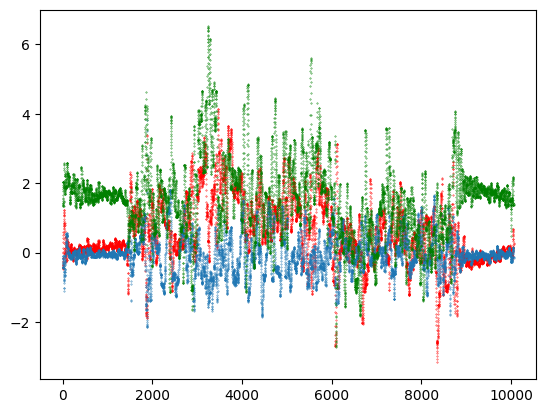

In [33]:
plt.scatter(range(len(axis[0])), axis[0], s=0.1, c ='r') #сырые значения полученные с акселерометров
plt.scatter(range(len(axis[1])), axis[1], s=0.1)
plt.scatter(range(len(axis[2])), axis[2], s=0.1,c ='g')

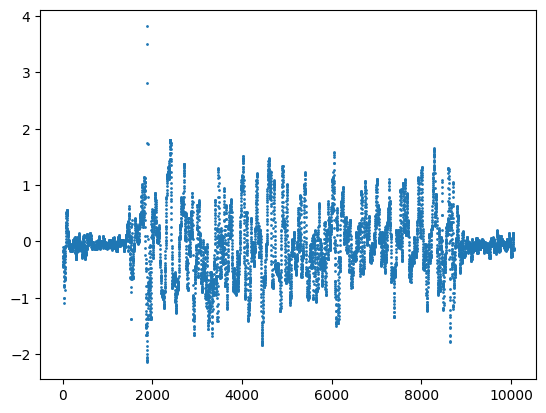

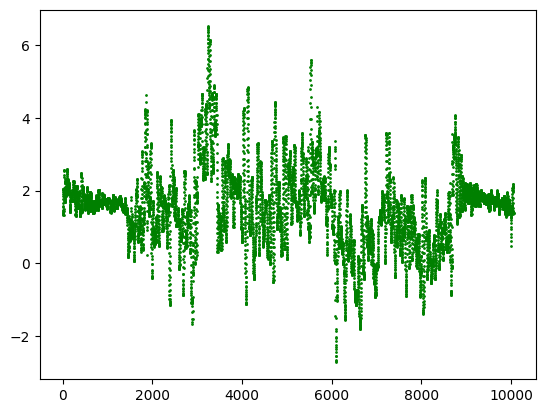

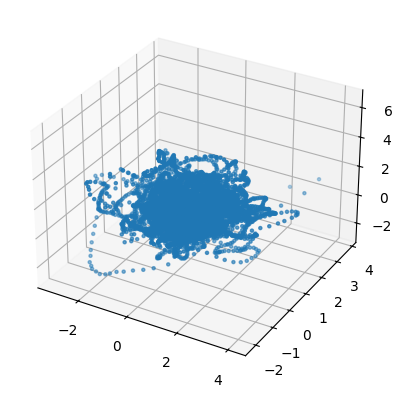

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(axis[0], axis[1], axis[2], marker='.') # геометрическое место концов векторов неотфильтрованных ускорений

In [8]:
def moving_average_cumsum(data, window_size):
    '''
    скользящее среднее по элементам массива
    '''
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

In [12]:
def treshold(data, treshold):
    '''
    зануление элементов массива чье абсолютное значение меньше порогового
    '''
    for i in range(len(data)):
                if abs(data[i]) < treshold:
                        data[i] = 0
        
    return data

In [14]:
def unbais (rdata):
    """
    вычитание средноегоарифметического массива из каждого его члена
    """
    data = rdata
    for i in range(len(data)):
                data[i] -= np.mean(data)
    return data

In [15]:
def MUT_filter (data, t = 0.25, low_board = 10, high_board = 400, trust = 30, soft = True, ubf = True):
    """
    фильтр для обработки данных ускорений и угловых скоростей

    t - порог отсева 
    low_board , high_board 
    границы области в которой выбирается значение шинины скользящего окна, критерием выбора ширины окна
    является минимизация среднего арифметического от фильтруемой последовательности,
    делается это для минимизации значения интегралла по последовательности, данное допущение справедливо только в том сллучае
    если начало и конец измерения происходят при нулевых скорости и ускорении, что в рамках эксперимента гарантируется

    trust - число последовательных попыток после нахождения минмального отклонения среднего арифметического при значении ширины окна w
    формально - порог проверки на то я влятся ли w оптимальным


    ubf - параметр масштабирования максимумов и минимумов, при фильтрации скоростей должен быть выключен во избежание ошибок интегрирования
    """
    w = -1
    loss = 1
    ovf_rate = trust
    for i in range(low_board,high_board):
        if ovf_rate == 60:
            break
        l1 = moving_average_cumsum(data,i)
        if ubf:
            l2 = unbais(l1)
        else:
            l2 = l1
        l3 = treshold(l2, t * max(l2))
        if np.mean(l3) < loss:
            loss = np.mean(l3)
            w = i
            ovf_rate = 0
        else:
            ovf_rate += 1
    
    if soft:
        l4 = moving_average_cumsum(l3,int(w/2))
        l4 = unbais(l4)
    else:
        l4 = l3
        
    delta_scale = (max(data)-min(data)) / (max(l4)-min(l4))
    print(loss, w)
    
    wtf_lost = len(data) - len(l4)
    l4 = np.append(l4, [0] * int(wtf_lost/2)) 
    l4 = np.append([0] * int(np.ceil(wtf_lost/2)), l4)
        
    return l4 * delta_scale if ubf else l4

In [16]:
#применение фильтров
filtered_axis = [[],[],[]]
filtered_axis[0] = MUT_filter(axis[0])
filtered_axis[1] = MUT_filter(axis[1])
filtered_axis[2] = MUT_filter(axis[2])

0.25091203216836316 10
-0.01711662761136493 12
0.32232099030767425 10


In [17]:
filtered_rotates = [[],[],[]]
filtered_rotates[0] = MUT_filter(rotates[0], ubf=False)
filtered_rotates[1] = MUT_filter(rotates[1], ubf=False)
filtered_rotates[2] = MUT_filter(rotates[2], ubf=False)

0.024806862847506408 16
-0.038635836202169184 245
0.0022386190295590916 12


In [18]:
#рекурентное применение фильтра к ускорениям, экспериментально замечено, при определенных параметрах фильтра
# и при правильной глубине рекурсии ошибка локализации сильно уменьшается в данном примере данные значения уже подобраны
# для используемой выборки
for _ in range(3):
    filtered_axis[0] = MUT_filter(filtered_axis[0])
    filtered_axis[1] = MUT_filter(filtered_axis[1])
    filtered_axis[2] = MUT_filter(filtered_axis[2])

0.18984098014220854 258
-0.019370115273756917 10
0.3786025648097432 10
0.24699678791478372 399
-0.013316757874534815 45
0.29727574799788004 194
0.1730352904391172 399
-0.0016851355130063856 12
0.32260835377156 399


In [19]:
#визуализация отфильтрованных значений

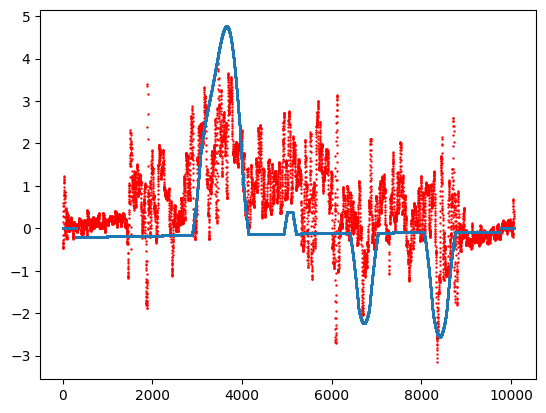

In [36]:
plt.scatter(range(len(axis[0])), axis[0], s=.5, c = 'r')
plt.scatter(range(len(filtered_axis[0])), filtered_axis[0], s=1)


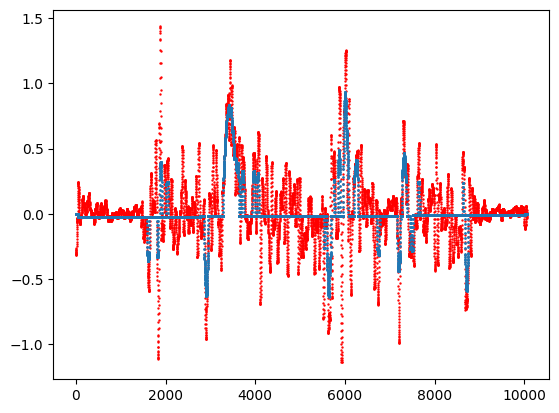

In [21]:
plt.scatter(range(len(axis[0])), rotates[0], s=.5, c = 'r')
plt.scatter(range(len(filtered_rotates[0])), filtered_rotates[0], s=1)

In [22]:
# задержка между измерениями в среднем равна
delta_t = 0.0048272 
#изменениями в 7-ом знаке принебрежем, примем задержку постоянной

In [23]:

filtered_angles = filtered_rotates #кусочно линейное интегрирование угловых скоростей дор углов

for i in range(3):
    for j in range(1, len(filtered_angles[0])):
        filtered_angles[i][j] += filtered_angles[i][j-1]
for i in range(3):
    filtered_angles[i] *= delta_t

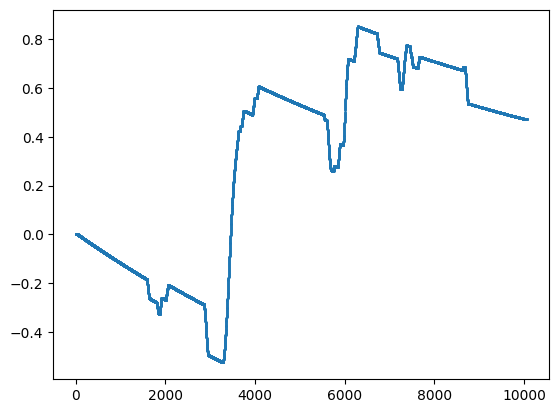

In [24]:

plt.scatter(range(len(filtered_angles[0])), filtered_angles[0] , s=1)
# значения угла снятые гироскором х, после интегрирования

In [25]:
def correlate_with_angles(axis, angles):
    """
    получение абсолютных значений координат из моментальныых значений ускорений по осям системы координат прибора (данные акселерометров)
    и углов наклона данной системы координат отностительно глобальной системы координат (интеграл от угловых скоростей)
    """
    abs_cords = [[0],[0],[0]]
    for i in range(1, len(axis[0])):
        dx = axis[0][i] - axis[0][i-1]
        dy = axis[1][i] - axis[1][i-1]
        dz = axis[2][i] - axis[2][i-1]

        abs_cords[0].append(-dy*np.sin(angles[2][i])*np.cos(angles[0][i])
                               +dx*np.cos(angles[2][i])*np.cos(angles[1][i])
                               +dz*np.sin(angles[0][i])*np.cos(angles[1][i])
                               + abs_cords[0][-1])
        abs_cords[1].append(dy*np.cos(angles[0][i])*np.cos(angles[2][i])
                               +dx*np.sin(angles[2][i])*np.cos(angles[1][i])
                               -dz*np.sin(angles[0][i])*np.cos(angles[1][i])
                               + abs_cords[1][-1])
        abs_cords[2].append(dy*np.sin(angles[0][i])*np.cos(angles[2][i])
                               -dx*np.sin(angles[1][i])*np.cos(angles[2][i])
                               +dz*np.cos(angles[0][i])*np.cos(angles[1][i])
                               + abs_cords[2][-1])
    return abs_cords

In [26]:
ans_cords = correlate_with_angles(filtered_axis,filtered_angles)

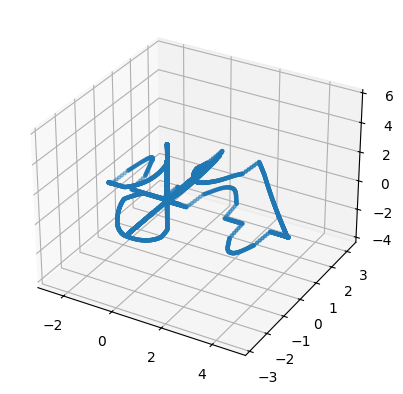

In [27]:
fig_fil = plt.figure()
ax_fil = fig_fil.add_subplot(projection='3d')
ax_fil.scatter(filtered_axis[0], filtered_axis[1], filtered_axis[2], marker='.')
# геометрическое место концов векторов ускоренй после фильтрации

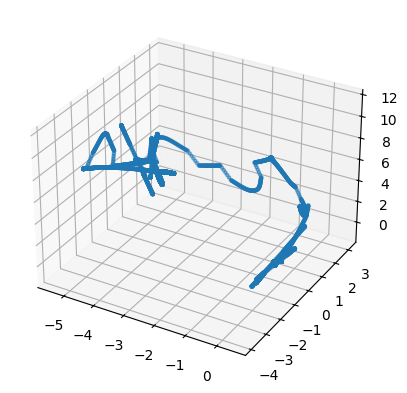

In [28]:
fig_fil = plt.figure()
ax_fil = fig_fil.add_subplot(projection='3d')
ax_fil.scatter(ans_cords[0], ans_cords[1], ans_cords[2], marker='.')
#результат

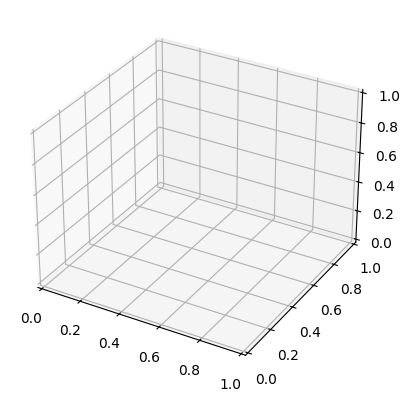

In [30]:
fig_fil = plt.figure()
ax_fil = fig_fil.add_subplot(projection='3d')
ax_fil.scatter([],[],[] )

In [ ]:
plt.scatter(range(len(moving_average_cumsum(axis[0], 800))),moving_average_cumsum(axis[0], 800), s=1, c ='r')

In [ ]:
plt.scatter(range(len(moving_average_cumsum(axis[1], 800))),moving_average_cumsum(axis[1], 800), s=1, c ='r')

In [ ]:
plt.scatter(range(len(moving_average_cumsum(axis[2], 800))),moving_average_cumsum(axis[2], 800), s=1, c ='r')

In [ ]:
plt.scatter(range(len(axis[0])), rotates[0], s=1, c ='g')

In [ ]:
plt.scatter(range(len(axis[0])), rotates[1], s=1, c ='g')

In [ ]:
plt.scatter(range(len(axis[0])), rotates[2], s=1, c ='g')

In [ ]:
plt.scatter(range(len(filtered_angles[0])), filtered_angles[0] , s=1)

In [ ]:
plt.scatter(range(len(filtered_angles[0])), filtered_angles[1] , s=1)

In [ ]:
plt.scatter(range(len(filtered_angles[0])), filtered_angles[2] , s=1)

In [ ]:
plt.scatter(range(len(ans_cords[0])), ans_cords[0] , s=1)

In [ ]:
plt.scatter(range(len(ans_cords[0])), ans_cords[1] , s=1)

In [ ]:
plt.scatter(range(len(ans_cords[0])), ans_cords[2] , s=1)